In [2]:
import os
import requests

def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()  # ensure we notice bad responses
    with open(dest_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"Downloaded file saved to {dest_path}")

# Replace this with your Bitly link
dataset_url = "https://bit.ly/4jnPqPB"

# Check if file already exists
dataset_path = "data/mushroom_dataset.csv"  # change the filename as needed
if not os.path.exists(dataset_path):
    user_input = input("Dataset not found. Would you like to download it? (y/n): ")
    if user_input.lower() == 'y':
        download_file(dataset_url, dataset_path)
    else:
        print("Dataset download skipped. Please ensure the dataset is in the correct path before running the code.")
else:
    print("Dataset already exists.")


Dataset already exists.


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset (adjust the filename/path as needed)
df = pd.read_csv("data/mushroom_dataset.csv")

# Display first few rows to understand the structure
print("Original Data Sample:")
print(df.head())

# Initialize a dictionary to store label encoders for each column (in case you need to reverse the encoding later)
label_encoders = {}

# Apply Label Encoding to each column
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nLabel Encoded Data Sample:")
print(df.head())

Original Data Sample:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p 

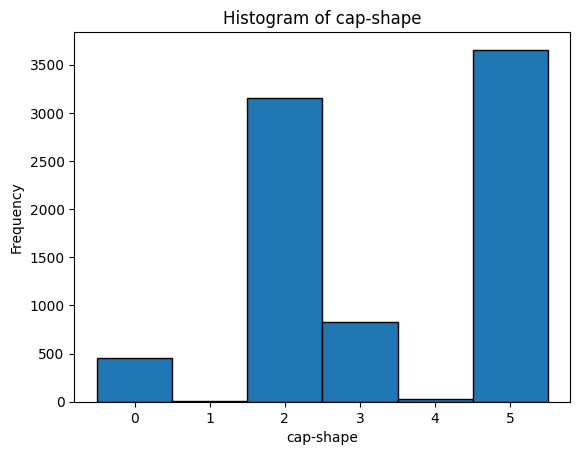

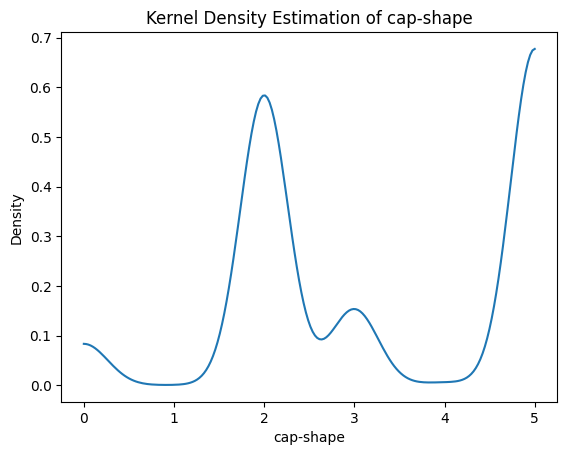

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


# Select a feature to visualize. For example, "cap-shape".
feature = 'cap-shape'
data = df[feature]

# ---------------------------
# 1. Histogram Plot
# ---------------------------
plt.figure()
# Create bins centered on each integer value representing each category.
bins = np.arange(data.min(), data.max() + 2) - 0.5
plt.hist(data, bins=bins, edgecolor='black')
plt.title(f'Histogram of {feature}')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.xticks(np.arange(data.min(), data.max() + 1))
plt.show()

# ---------------------------
# 2. Kernel Density Estimation (KDE) Plot
# ---------------------------
# Note: KDE plots are generally used for continuous data. Since our feature is categorical,
# the KDE plot is only for exploratory purposes.
plt.figure()
# Calculate the density using Gaussian KDE
density = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 200)
plt.plot(x_vals, density(x_vals))
plt.title(f'Kernel Density Estimation of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.show()


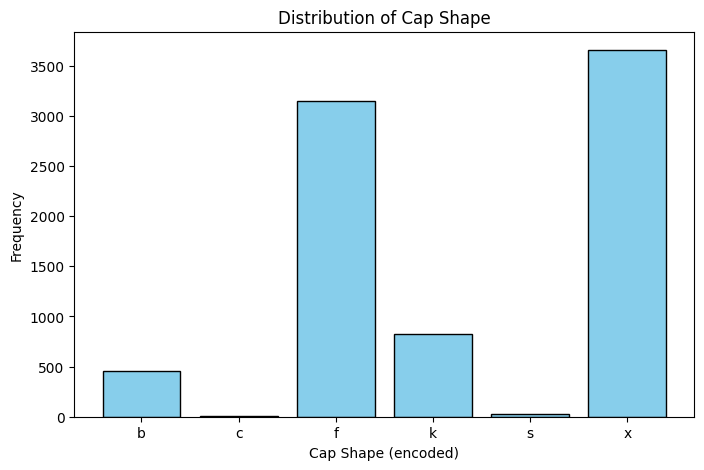

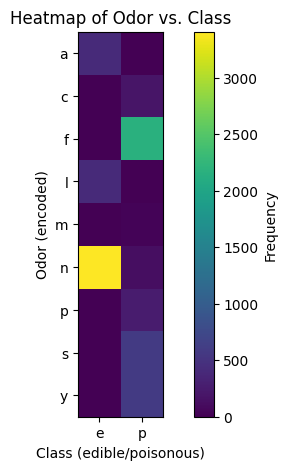

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (update the path/filename as needed)
df = pd.read_csv("data/mushroom_dataset.csv")

# Example: Using 'cap-shape' as a feature to visualize its distribution.
# Assuming the CSV is already label encoded.
# If not, you can run LabelEncoder on 'cap-shape' as shown earlier.

# ---------------------------
# Bar Plot for 'cap-shape'
# ---------------------------
plt.figure(figsize=(8, 5))
# Count the occurrences of each category in 'cap-shape'
cap_shape_counts = df['cap-shape'].value_counts().sort_index()
plt.bar(cap_shape_counts.index, cap_shape_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribution of Cap Shape')
plt.xlabel('Cap Shape (encoded)')
plt.ylabel('Frequency')
plt.xticks(cap_shape_counts.index)  # these are encoded values
plt.show()

# ---------------------------
# Heatmap for two categorical features: 'odor' and 'class'
# ---------------------------
# Create a cross-tabulation (contingency table) between 'odor' and 'class'
crosstab = pd.crosstab(df['odor'], df['class'])

plt.figure(figsize=(8, 5))
plt.imshow(crosstab, cmap='viridis', interpolation='nearest')
plt.title('Heatmap of Odor vs. Class')
plt.xlabel('Class (edible/poisonous)')
plt.ylabel('Odor (encoded)')
plt.colorbar(label='Frequency')

# Set ticks and labels using the crosstab index and columns
plt.xticks(np.arange(len(crosstab.columns)), crosstab.columns)
plt.yticks(np.arange(len(crosstab.index)), crosstab.index)
plt.show()




foul smelling mushrooms seem to be poisonous really often,
no odor mushrooms seem to be edible really often
and it seems like there isn't much of a pattern for other odors (like fishy odors, creosote, almond, anise)

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam

# Load the dataset (assumes it's already label encoded)
df = pd.read_csv("data/mushroom_dataset.csv")

# Assume the target column is 'class' (for edible vs poisonous)
features = [col for col in df.columns if col != 'class']

# Create a list for inputs and embeddings
embedding_inputs = []
embedding_layers = []

# For each feature, set up an input and an embedding layer.
# We'll use a simple heuristic for the embedding dimension: min(50, (n_categories + 1) // 2)
for feature in features:
    n_categories = df[feature].nunique()
    embed_dim = min(50, (n_categories + 1) // 2)

    # Input layer for this feature
    input_f = Input(shape=(1,), name=f"{feature}_input")
    embedding_inputs.append(input_f)

    # Embedding layer: input_dim is n_categories and output_dim is embed_dim.
    embed_layer = Embedding(input_dim=n_categories, output_dim=embed_dim, name=f"{feature}_embedding")(input_f)
    embed_layer = Flatten()(embed_layer)
    embedding_layers.append(embed_layer)

# Concatenate all the embeddings
concatenated = Concatenate()(embedding_layers)

# Add a couple of dense layers (adjust as needed)
dense = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense)

# Build the model
model = Model(inputs=embedding_inputs, outputs=output)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cap-shape_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cap-surface_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cap-color_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bruises_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ odor_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-attachment_in… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-spacing_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-size_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-color_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-shape_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-root_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-surface-abov… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-surface-belo… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-color-above-… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-color-below-… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ veil-type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ veil-color_input    │ (None, 1)         │          0 │ -               

 Total params: 4,606 (17.99 KB)

 Trainable params: 4,606 (17.99 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import math

In [8]:
dataset_path = "data/mushroom_dataset.csv"
if not os.path.exists(dataset_path):
    raise FileNotFoundError("Dataset not found.")

df = pd.read_csv(dataset_path)

# Create a dictionary to store encoders (if you need to reverse the encoding later)
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("Original Label Encoded Data Sample:")
print(df.head())

# Prepare Data for Tree Building
target_col = 'class'
feature_names = [col for col in df.columns if col != target_col]
X = df[feature_names].values  # Features as numpy array
y = df[target_col].values     # Target labels as numpy array


Original Label Encoded Data Sample:
   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  ...  stalk-surface-below-ring  \
0             0          1           4  ...                         2   
1             0          0           4  ...                         2   
2             0          0           5  ...                         2   
3             0          1           5  ...                         2   
4             1          0           4  ...                         2   

   stalk-color-above-ring  stalk-color-below-ring 

In [9]:
# Helper Functions: Entropy, Information Gain & Majority Class
def entropy(y):
    """Compute the entropy of a label distribution."""
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    # Adding a small epsilon to avoid log2(0) issues.
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

def information_gain(X, y, feature_index):
    """
    Compute the information gain obtained by splitting on the column at feature_index.
    X : 2D numpy array with shape (n_samples, n_features) from the current sub-problem.
    y : 1D numpy array of labels corresponding to X.
    feature_index: integer index in the current feature set.
    """
    total_entropy = entropy(y)
    values, counts = np.unique(X[:, feature_index], return_counts=True)
    weighted_entropy = 0
    for i, val in enumerate(values):
        subset_y = y[X[:, feature_index] == val]
        weighted_entropy += counts[i] / len(y) * entropy(subset_y)
    return total_entropy - weighted_entropy

def most_common(y):
    """Return the most common label in y."""
    unique, counts = np.unique(y, return_counts=True)
    return unique[np.argmax(counts)]


In [10]:
# Decision Tree Implementation (ID3)
class Node:
    def __init__(self, feature_index=None, value=None, branches=None, is_leaf=False):
        """
        A Node in the decision tree.
          - feature_index: index (in the current feature array) of the feature used for splitting.
          - value: if internal, this is the feature (name) used to split; if leaf, the predicted label.
          - branches: dictionary mapping each feature value to a child Node.
          - is_leaf: flag indicating whether this node is a leaf.
        """
        self.feature_index = feature_index
        self.value = value
        self.branches = branches if branches is not None else {}
        self.is_leaf = is_leaf

class DecisionTreeClassifierCustom:
    def __init__(self):
        self.tree = None
        self.original_feature_names = None

    def fit(self, X, y, feature_names):
        """
        Build the decision tree using the training data.
          X: 2D array of features.
          y: 1D array of labels.
          feature_names: list of feature names corresponding to the columns of X.
        """
        self.original_feature_names = feature_names.copy()
        self.tree = self._build_tree(X, y, feature_names)

    def _build_tree(self, X, y, feature_names):
        # If only one class remains, return a leaf node with that class.
        if len(np.unique(y)) == 1:
            return Node(is_leaf=True, value=y[0])
        # If no more features to split on, return a leaf node with the majority class.
        if len(feature_names) == 0:
            return Node(is_leaf=True, value=most_common(y))

        # Compute information gain for each feature in the current feature set.
        gains = [information_gain(X, y, i) for i in range(len(feature_names))]
        best_feature_index = np.argmax(gains)
        best_feature_gain = gains[best_feature_index]
        best_feature_name = feature_names[best_feature_index]

        # If the best gain is zero, no further splitting is useful.
        if best_feature_gain == 0:
            return Node(is_leaf=True, value=most_common(y))

        # Create an internal node that splits on the best feature.
        node = Node(feature_index=best_feature_index, value=best_feature_name, is_leaf=False)
        feature_values = np.unique(X[:, best_feature_index])

        # For each value of the best feature, build a subtree.
        for value in feature_values:
            indices = np.where(X[:, best_feature_index] == value)[0]
            X_subset = X[indices, :]
            y_subset = y[indices]

            # Remove the best feature column from X_subset.
            X_subset = np.delete(X_subset, best_feature_index, axis=1)
            # Remove the corresponding feature name.
            new_feature_names = feature_names.copy()
            new_feature_names.pop(best_feature_index)

            # Recursively build the subtree and assign it to the branch for this feature value.
            node.branches[value] = self._build_tree(X_subset, y_subset, new_feature_names)
        return node

    def predict_sample(self, x, tree, feature_names):
        """
        Recursively traverse the tree to predict the label for a single sample.
          x: 1D numpy array representing one sample's feature values.
          tree: current node (starting with the root).
          feature_names: list of feature names corresponding to x.
        """
        if tree.is_leaf:
            return tree.value
        index = tree.feature_index
        feature_val = x[index]
        if feature_val in tree.branches:
            subtree = tree.branches[feature_val]
        else:
            # If a feature value is not present in the branches, fall back to majority class among branches.
            predictions = [self._get_majority_class(sub) for sub in tree.branches.values()]
            return max(set(predictions), key=predictions.count)
        # Remove the used feature from x and feature_names for the recursive call.
        new_x = np.delete(x, index)
        new_feature_names = feature_names.copy()
        new_feature_names.pop(index)
        return self.predict_sample(new_x, subtree, new_feature_names)

    def predict(self, X):
        """
        Predict labels for a set of instances.
          X: 2D numpy array of instances.
        """
        predictions = []
        for x in X:
            predictions.append(self.predict_sample(x, self.tree, self.original_feature_names.copy()))
        return np.array(predictions)

    def _get_majority_class(self, node):
        """Recursively obtain the majority class from the subtree rooted at node."""
        if node.is_leaf:
            return node.value
        values = [self._get_majority_class(branch) for branch in node.branches.values()]
        return max(set(values), key=values.count)


In [11]:
def print_tree(node, feature_names, indent=""):
    """
    Recursively prints the structure of the decision tree.
      node: current Node.
      feature_names: current list of feature names.
      indent: string used for indentation (for readability).
    """
    if node.is_leaf:
        # For leaves, print the predicted class.
        print(indent + "Leaf:", node.value)
    else:
        # For internal nodes, print the feature used.
        print(indent + "Feature:", node.value)
        for branch_val, subtree in node.branches.items():
            print(indent + f" -> If {node.value} == {branch_val}:")
            # Copy feature_names and remove the used feature.
            new_feature_names = feature_names.copy()
            if node.value in new_feature_names:
                new_feature_names.remove(node.value)
            print_tree(subtree, new_feature_names, indent + "    ")


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_classifier = DecisionTreeClassifierCustom()
tree_classifier.fit(X_train, y_train, feature_names.copy())


print("\nDecision Tree Structure:")
print_tree(tree_classifier.tree, feature_names.copy())



Decision Tree Structure:
Feature: odor
 -> If odor == 0:
    Leaf: 0
 -> If odor == 1:
    Leaf: 1
 -> If odor == 2:
    Leaf: 1
 -> If odor == 3:
    Leaf: 0
 -> If odor == 4:
    Leaf: 1
 -> If odor == 5:
    Feature: spore-print-color
     -> If spore-print-color == 0:
        Leaf: 0
     -> If spore-print-color == 1:
        Leaf: 0
     -> If spore-print-color == 2:
        Leaf: 0
     -> If spore-print-color == 3:
        Leaf: 0
     -> If spore-print-color == 4:
        Leaf: 0
     -> If spore-print-color == 5:
        Leaf: 1
     -> If spore-print-color == 7:
        Feature: habitat
         -> If habitat == 0:
            Feature: gill-size
             -> If gill-size == 0:
                Leaf: 0
             -> If gill-size == 1:
                Leaf: 1
         -> If habitat == 1:
            Leaf: 0
         -> If habitat == 2:
            Feature: cap-color
             -> If cap-color == 1:
                Leaf: 0
             -> If cap-color == 4:
              

In [13]:
train_preds = tree_classifier.predict(X_train)
test_preds = tree_classifier.predict(X_test)

train_accuracy = np.mean(train_preds == y_train)
test_accuracy = np.mean(test_preds == y_test)

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


Training Accuracy: 100.00%
Test Accuracy: 100.00%


In [14]:
encoding_maps = {
    'class':          {'e': 'edible',     'p': 'poisonous'},
    'cap-shape':      {'b': 'bell',       'c': 'conical',  'x': 'convex',
                       'f': 'flat',       'k': 'knobbed',  's': 'sunken'},
    'cap-surface':    {'f': 'fibrous',    'g': 'grooves',  'y': 'scaly',
                       's': 'smooth'},
    'cap-color':      {'n': 'brown',      'b': 'buff',     'c': 'cinnamon',
                       'g': 'gray',       'r': 'green',    'p': 'pink',
                       'u': 'purple',     'e': 'red',      'w': 'white',
                       'y': 'yellow'},
    'bruises':        {'t': 'bruises',    'f': 'no'},
    'odor':           {'a': 'almond',     'l': 'anise',    'c': 'creosote',
                       'y': 'fishy',      'f': 'foul',     'm': 'musty',
                       'n': 'none',       'p': 'pungent',  's': 'spicy'},
    'gill-attachment':{'a': 'attached',   'd': 'descending','f': 'free',
                       'n': 'notched'},
    'gill-spacing':   {'c': 'close',      'w': 'crowded',  'd': 'distant'},
    'gill-size':      {'b': 'broad',      'n': 'narrow'},
    'gill-color':     {'k': 'black',      'n': 'brown',    'b': 'buff',
                       'h': 'chocolate',  'g': 'gray',     'r': 'green',
                       'o': 'orange',     'p': 'pink',     'u': 'purple',
                       'e': 'red',        'w': 'white',    'y': 'yellow'},
    'stalk-shape':    {'e': 'enlarging',  't': 'tapering'},
    'stalk-root':     {'b': 'bulbous',    'c': 'club',     'u': 'cup',
                       'e': 'equal',      'z': 'rhizomorphs','r': 'rooted',
                       '?': 'missing'},
    'stalk-surface-above-ring': {'f':'fibrous','y':'scaly','k':'silky','s':'smooth'},
    'stalk-surface-below-ring': {'f':'fibrous','y':'scaly','k':'silky','s':'smooth'},
    'stalk-color-above-ring':   {'n':'brown','b':'buff','c':'cinnamon',
                                 'g':'gray','o':'orange','p':'pink',
                                 'e':'red','w':'white','y':'yellow'},
    'stalk-color-below-ring':   {'n':'brown','b':'buff','c':'cinnamon',
                                 'g':'gray','o':'orange','p':'pink',
                                 'e':'red','w':'white','y':'yellow'},
    'veil-type':      {'p': 'partial',    'u': 'universal'},
    'veil-color':     {'n': 'brown',      'o': 'orange',   'w': 'white',
                       'y': 'yellow'},
    'ring-number':    {'n': 'none',       'o': 'one',      't': 'two'},
    'ring-type':      {'c': 'cobwebby',   'e': 'evanescent','f': 'flaring',
                       'l': 'large',      'n': 'none',     'p': 'pendant',
                       's': 'sheathing',  'z': 'zone'},
    'spore-print-color': {'k':'black','n':'brown','b':'buff','h':'chocolate',
                          'r':'green','o':'orange','u':'purple','w':'white',
                          'y':'yellow'},
    'population':     {'a': 'abundant',   'c': 'clustered', 'n': 'numerous',
                       's': 'scattered',  'v': 'several',   'y': 'solitary'},
    'habitat':        {'g': 'grasses',    'l': 'leaves',    'm': 'meadows',
                       'p': 'paths',      'u': 'urban',     'w': 'waste',
                       'd': 'woods'}
}


In [15]:
def print_tree_with_codes(node, feature_names, label_encoders, encoding_maps, target_col='class', indent=""):
    """
    Prints each split and leaf using the original single-letter code
    plus its human-readable meaning.
    """
    if node.is_leaf:
        # recover the single-letter code
        code = label_encoders[target_col].inverse_transform([node.value])[0]
        desc = encoding_maps[target_col].get(code, code)
        print(f"{indent}Leaf: {code} ({desc})")
    else:
        feat = node.value
        print(f"{indent}Feature: {feat}")
        for code_int, subtree in node.branches.items():
            # map back to the letter
            letter = label_encoders[feat].inverse_transform([code_int])[0]
            desc   = encoding_maps[feat].get(letter, letter)
            print(f"{indent} -> If {feat} == {letter} ({desc}):")
            # recurse, dropping this feature
            child_feats = [f for f in feature_names if f != feat]
            print_tree_with_codes(subtree, child_feats, label_encoders, encoding_maps, target_col, indent + "    ")


In [16]:
print_tree_with_codes(tree_classifier.tree, feature_names.copy(), label_encoders, encoding_maps, target_col='class')

Feature: odor
 -> If odor == a (almond):
    Leaf: e (edible)
 -> If odor == c (creosote):
    Leaf: p (poisonous)
 -> If odor == f (foul):
    Leaf: p (poisonous)
 -> If odor == l (anise):
    Leaf: e (edible)
 -> If odor == m (musty):
    Leaf: p (poisonous)
 -> If odor == n (none):
    Feature: spore-print-color
     -> If spore-print-color == b (buff):
        Leaf: e (edible)
     -> If spore-print-color == h (chocolate):
        Leaf: e (edible)
     -> If spore-print-color == k (black):
        Leaf: e (edible)
     -> If spore-print-color == n (brown):
        Leaf: e (edible)
     -> If spore-print-color == o (orange):
        Leaf: e (edible)
     -> If spore-print-color == r (green):
        Leaf: p (poisonous)
     -> If spore-print-color == w (white):
        Feature: habitat
         -> If habitat == d (woods):
            Feature: gill-size
             -> If gill-size == b (broad):
                Leaf: e (edible)
             -> If gill-size == n (narrow):
            